In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import os
import pprint

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RNN
from keras.layers import SimpleRNN
from keras.layers import Bidirectional
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#(Preprocessing and Normalization) , (Naive Baseline)

In [ ]:
dataset = pd.read_csv('Processed_S&P.csv')
dataset = dataset[["Date", "Close"]]

In [ ]:
dataset["Labels"] = 0

In [ ]:
dataset['Close'] = dataset['Close'].astype(float)

In [ ]:
#dataset

In [ ]:
for i in range (1, len(dataset)):
  if dataset["Close"].iloc[i] > dataset["Close"].iloc[i-1]:
    dataset["Labels"].iloc[i] = 1

  else:
    dataset["Labels"].iloc[i] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#dataset

In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index(dataset['Date'])
dataset = dataset.sort_index()

In [ ]:
train = dataset['2009-12-31':'2016-05-06']
test  = dataset['2016-05-06':]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (1598, 3)
Test Dataset: (387, 3)


In [ ]:
train = train.dropna(axis = 0)
test  = test.dropna(axis = 0)

In [ ]:
def Moving_Average(dataset, period = 5, column = 'Close'):
  return dataset[column].rolling(window = period).mean()

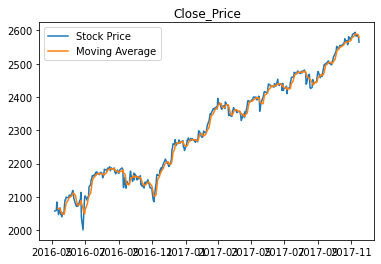

In [ ]:
plt.title("Close_Price")
plt.plot(test['Close'], label = 'Stock Price')
plt.plot(Moving_Average(test), label = 'Moving Average')
plt.legend()
plt.show()

In [ ]:
test['Moving Average'] = Moving_Average(test)

In [ ]:
test["Naive_Labels"] = 0
test['Moving Average'] = test['Moving Average'].astype(float)

In [ ]:
for i in range (1, len(test)):
  if test['Moving Average'].iloc[i] > test['Moving Average'].iloc[i-1]:
    test["Naive_Labels"].iloc[i] = 1

  else:
    test["Naive_Labels"].iloc[i] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
True_Labels = test.iloc[:,2]
Naive_Labels= test.iloc[:,4]

In [ ]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(Naive_Labels, True_Labels)
print("Accuracy with Naive_Baseline: ",score_naive)

Accuracy with Naive_Baseline:  0.6692506459948321


# More Preprocessing

In [ ]:
Train_Data = train.iloc[:, 1:2].values
Train_Labels = train.iloc[:, 2:3].values
Test_Data = test.iloc[:, 1:2]
Test_Labels = test.iloc[:, 2:3].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(Train_Data)

In [ ]:
Train_Data.size

1598

In [ ]:
x_train = []
for i in range(50, 1598):  
    x_train.append(training_set_scaled[i-50:i, 0])
x_train = np.array(x_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1548, 50, 1)

In [ ]:
Train_Labels = Train_Labels[50:]
Train_Labels.shape

(1548, 1)

In [ ]:
test = test.drop(['Date'], axis=1)
train = train.drop(['Date'], axis=1)

In [ ]:
dataset_total = pd.concat((train['Close'], test['Close']), axis = 0)

In [ ]:
inputs = dataset_total[len(dataset_total) - len(test) - 50:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
x_test = []
for i in range(50, 437):
    x_test.append(inputs[i-50:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Simple Model

In [ ]:
classifier_A = Sequential()

In [ ]:
classifier_A.add(LSTM(units = 10, return_sequences = True, input_shape = (x_train.shape[1], 1)))
classifier_A.add(Dropout(0.2))

classifier_A.add(LSTM(units = 10, return_sequences = True))
classifier_A.add(Dropout(0.2))

classifier_A.add(LSTM(units = 10))
classifier_A.add(Dropout(0.2))

classifier_A.add(Dense(units = 1))

In [ ]:
'''
classifier_A.add(Bidirectional(LSTM(units = 10, return_sequences = True, input_shape = (x_train.shape[1], 1))))
classifier_A.add(Dropout(0.2))

classifier_A.add(Bidirectional(LSTM(units = 10, return_sequences = True)))
classifier_A.add(Dropout(0.2))

classifier_A.add(Bidirectional(LSTM(units = 10)))
classifier_A.add(Dropout(0.2))

classifier_A.add(Dense(units = 1))
'''

'\nclassifier_A.add(Bidirectional(LSTM(units = 10, return_sequences = True, input_shape = (x_train.shape[1], 1))))\nclassifier_A.add(Dropout(0.2))\n\nclassifier_A.add(Bidirectional(LSTM(units = 10, return_sequences = True)))\nclassifier_A.add(Dropout(0.2))\n\nclassifier_A.add(Bidirectional(LSTM(units = 10)))\nclassifier_A.add(Dropout(0.2))\n\nclassifier_A.add(Dense(units = 1))\n'

In [ ]:
classifier_A.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#history = classifier.fit(x_train, Train_Labels, shuffle=True, epochs=100,
                       # callbacks=[es, rlr,mcp, tb], validation_split=0.2, verbose=1, batch_size=64)

In [ ]:
history = classifier_A.fit(x_train, Train_Labels, validation_data=(x_test, Test_Labels), epochs = 50, batch_size = 32)

Epoch 1/50
49/49 [==============================] - 9s 83ms/step - loss: 1.5151 - accuracy: 0.4587 - val_loss: 0.6913 - val_accuracy: 0.5504
Epoch 2/50
49/49 [==============================] - 3s 57ms/step - loss: 0.7769 - accuracy: 0.4903 - val_loss: 0.6915 - val_accuracy: 0.5504
Epoch 3/50
49/49 [==============================] - 3s 57ms/step - loss: 0.7508 - accuracy: 0.4677 - val_loss: 0.6885 - val_accuracy: 0.5504
Epoch 4/50
49/49 [==============================] - 3s 56ms/step - loss: 0.7236 - accuracy: 0.5006 - val_loss: 0.6917 - val_accuracy: 0.5504
Epoch 5/50
49/49 [==============================] - 3s 57ms/step - loss: 0.7198 - accuracy: 0.5200 - val_loss: 0.6890 - val_accuracy: 0.5504
Epoch 6/50
49/49 [==============================] - 3s 57ms/step - loss: 0.7217 - accuracy: 0.4864 - val_loss: 0.6887 - val_accuracy: 0.5504
Epoch 7/50
49/49 [==============================] - 3s 56ms/step - loss: 0.7081 - accuracy: 0.5097 - val_loss: 0.6922 - val_accuracy: 0.5504
Epoch 8/50
49

In [ ]:
print(classifier_A.evaluate(x_test, Test_Labels))

13/13 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.5504
[0.6913721561431885, 0.5503876209259033]


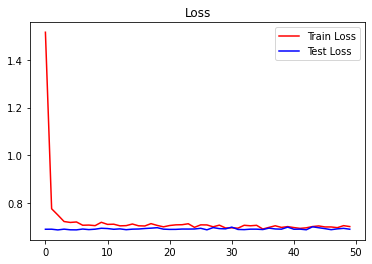

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'Train Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

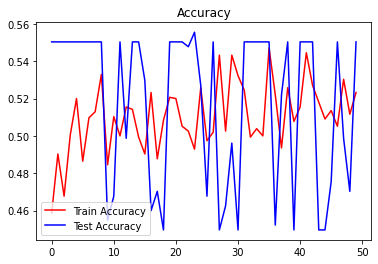

In [ ]:
plt.plot(history.history['accuracy'], color = 'red', label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Test Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
predicted_stock_price = classifier_A.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Advanced model



In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1548, 50, 1)

In [ ]:
x_train.shape

(1548, 50, 1)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],1,50,1)

In [ ]:
#dataset

In [ ]:
dataset = dataset.dropna(axis = 0)

In [ ]:
dataset.shape

(1984, 3)

In [ ]:
Timestamp = 50
X = []

In [ ]:
for i in range(0 , len(dataset) - Timestamp -1 , 1):
    first = dataset.iloc[i, 1]
    temp = []
    for j in range(Timestamp):
        temp.append((dataset.iloc[i + j, 1] - first) / first)
    X.append(np.array(temp).reshape(50, 1))

In [ ]:
X = np.array(X)
X.shape

(1933, 50, 1)

In [ ]:
Y = dataset['Labels']
Y = np.array(Y)
Y.shape

(1984,)

In [ ]:
Y = Y[51:]
Y.shape

(1933,)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],1,50,1)
X_test = X_test.reshape(X_test.shape[0],1,50,1)

In [ ]:
classifier_B = Sequential()

In [ ]:
classifier_B.add(TimeDistributed(Conv1D(16, kernel_size=1, activation='relu', input_shape=(None,50,1))))
classifier_B.add(TimeDistributed(MaxPooling1D(2)))
classifier_B.add(TimeDistributed(Conv1D(32, kernel_size=1, activation='relu')))
classifier_B.add(TimeDistributed(MaxPooling1D(2)))
classifier_B.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu')))
classifier_B.add(TimeDistributed(MaxPooling1D(2)))
classifier_B.add(TimeDistributed(Flatten()))
classifier_B.add(Bidirectional(LSTM(10,return_sequences=True)))
classifier_B.add(Dropout(0.25))
classifier_B.add(Bidirectional(LSTM(10,return_sequences=False)))
classifier_B.add(Dropout(0.25))
classifier_B.add(Dense(1, activation='linear'))
classifier_B.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

In [ ]:
history = classifier_B.fit(X_train, Y_train, validation_data=(X_test,Y_test), shuffle=True, epochs=100,
                        callbacks=[early_stop, reduce_LR, checkpoint, tb], verbose=1, batch_size=64)

Epoch 1/100
22/25 [=========================>....] - ETA: 0s - loss: 2.4006 - accuracy: 0.4581
Epoch 00001: val_loss improved from inf to 1.79259, saving model to weights.h5
25/25 [==============================] - 11s 96ms/step - loss: 2.3518 - accuracy: 0.4580 - val_loss: 1.7926 - val_accuracy: 0.4496 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.4024 - accuracy: 0.4580
Epoch 00002: val_loss improved from 1.79259 to 0.97423, saving model to weights.h5
25/25 [==============================] - 0s 14ms/step - loss: 1.4024 - accuracy: 0.4580 - val_loss: 0.9742 - val_accuracy: 0.4496 - lr: 0.0010
Epoch 3/100
22/25 [=========================>....] - ETA: 0s - loss: 0.7856 - accuracy: 0.4972
Epoch 00003: val_loss improved from 0.97423 to 0.69105, saving model to weights.h5
25/25 [==============================] - 0s 13ms/step - loss: 0.7819 - accuracy: 0.4974 - val_loss: 0.6910 - val_accuracy: 0.5504 - lr: 0.0010
Epoch 4/100
24/25 [=====================

In [ ]:
print(classifier_B.evaluate(X_test, Y_test))

13/13 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5504
[0.6918143630027771, 0.5503876209259033]


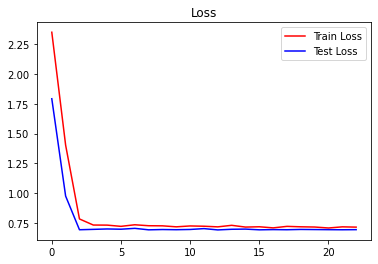

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'Train Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

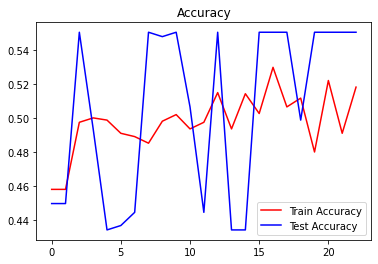

In [ ]:
plt.plot(history.history['accuracy'], color = 'red', label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Test Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()